# Spectrogram チュートリアル

このチュートリアルでは、**GWExPy** における `Spectrogram` クラスおよびそのコンテナである `SpectrogramList`, `SpectrogramDict` の使い方を解説します。

スペクトログラムは時間-周波数平面上の信号強度を表すデータ構造であり、非定常な信号の解析に不可欠です。

## 目次
1. [Spectrogram の基礎](#basic)
2. [SpectrogramList によるバッチ処理](#list)
3. [SpectrogramDict による管理](#dict)
4. [行列形式への変換と機械学習連携](#matrix)

<a id="basic"></a>
## 1. Spectrogram の基礎

### 生成
`TimeSeries` オブジェクトの `spectrogram()` メソッドを使用して生成します。

短時間フーリエ変換 (STFT) に基づき、各時刻 $t$ における周波数スペクトル $S(t, f)$ を計算します。

$$
S(t, f) = \left| \int_{-\infty}^{\infty} x(\tau) w(\tau - t) e^{-i 2\pi f \tau} d\tau \right|^2
$$

ここで $w(\tau)$ は窓関数です。

In [1]:
import numpy as np

from gwexpy.noise.wave import chirp, gaussian
from gwexpy.plot import Plot
from gwexpy.spectrogram import SpectrogramDict, SpectrogramList

# チャープ信号の生成
duration = 20
fs = 128
t = np.linspace(0, duration, duration*fs)
s = chirp(duration=duration, sample_rate=fs, f0=10, f1=40, t1=duration)
n = gaussian(duration=duration, sample_rate=fs, std=0.2)
ts = s + n
ts.name = 'Chirp Signal'

# スペクトログラムの計算
# stride: 時間ビンの幅 (秒), fftlength: FFT長 (秒), overlap: オーバーラップ (秒)
spec = ts.spectrogram(stride=1.0, fftlength=1.0, overlap=0.5, window='hann')

print(spec)

Spectrogram([[5.34938671e-05, 2.80263961e-04, 9.68050913e-04,
              ..., 1.10949273e-03, 1.56924493e-03,
              3.23017112e-05],
             [4.06164399e-04, 7.04905789e-04, 7.19927497e-04,
              ..., 9.36800539e-04, 1.79993895e-03,
              1.12768549e-03],
             [4.88656262e-05, 4.16620693e-04, 6.50053001e-04,
              ..., 3.83037138e-04, 5.08975166e-04,
              1.27321155e-04],
             ...,
             [2.36796516e-04, 4.18922464e-04, 2.33206089e-04,
              ..., 5.72377705e-04, 4.75003244e-04,
              2.21090005e-04],
             [3.60272265e-05, 7.47570441e-04, 3.22733259e-04,
              ..., 1.25745309e-03, 1.26412681e-03,
              5.60207453e-04],
             [1.08603050e-04, 5.34800750e-04, 2.96875807e-04,
              ..., 1.40553431e-03, 1.49509784e-03,
              5.82109639e-04]]
            unit: 1 / Hz,
            name: Chirp Signal,
            epoch: 0.0,
            channel: None,
         

### プロット
`plot()` メソッドで簡単に可視化できます。対数軸やカラーマップの調整も可能です。

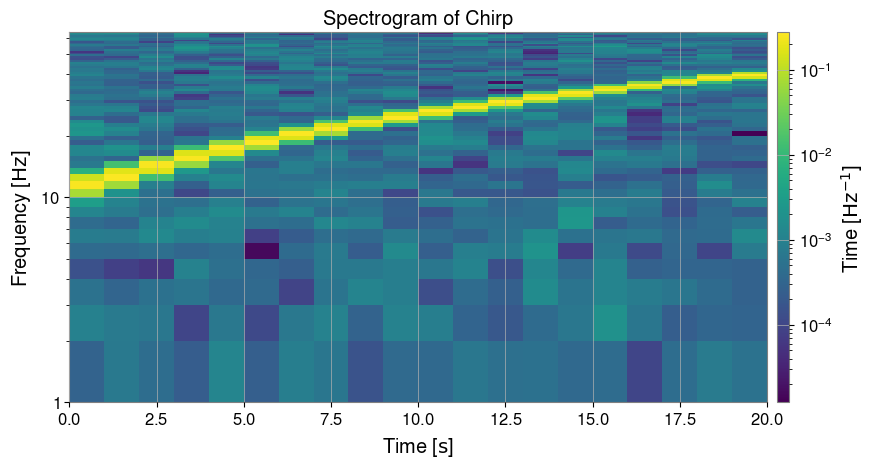

In [2]:
plot = Plot(spec, yscale='log', xscale='linear', title='Spectrogram of Chirp')
plot.show()

### 比率の計算 (`ratio`)

2つのスペクトログラム間の比率を計算し、変化を強調することができます。

$$
R(t, f) = \frac{S_{target}(t, f)}{S_{ref}(t, f)}
$$


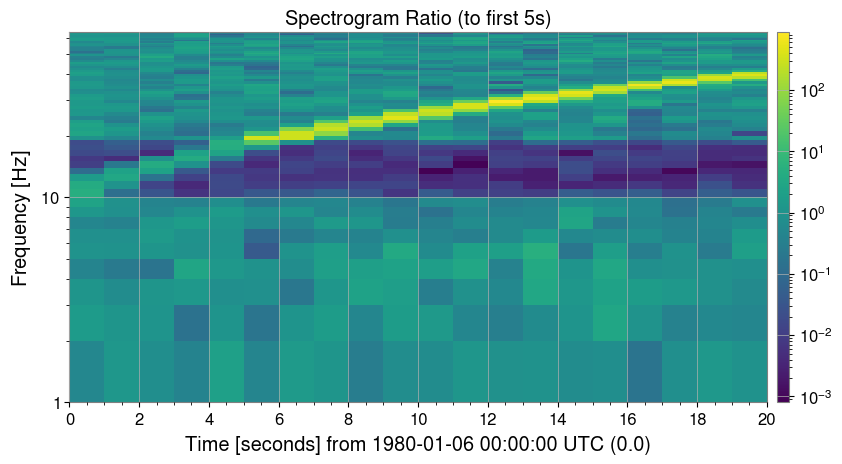

In [3]:
# 参照用として前半部分の平均スペクトルを使用
ref_spec = spec.crop(0, 5).mean(axis=0)
# Refを拡張して同じ形状にする（ブロードキャストを利用）
# 実際には `ratio` メソッドが自動的に処理する場合もありますが、ここでは除算を示します
spec_ratio = spec / ref_spec

plot = Plot(spec_ratio, norm='log', title='Spectrogram Ratio (to first 5s)')
plot.show()

<a id="list"></a>
## 2. SpectrogramList によるバッチ処理

`SpectrogramList` は複数の `Spectrogram` オブジェクトをリストとして管理し、一括操作を提供します。

In [4]:
from gwexpy.noise.wave import sine

# 複数の信号を作成
ts1 = sine(duration=20, sample_rate=128, frequency=10, amplitude=1.0) + gaussian(duration=20, sample_rate=128, std=0.1)
ts2 = sine(duration=20, sample_rate=128, frequency=30, amplitude=1.0) + gaussian(duration=20, sample_rate=128, std=0.1)

ts1.name = '10Hz Sine'
ts2.name = '30Hz Sine'

spec1 = ts1.spectrogram(stride=1, fftlength=1)
spec2 = ts2.spectrogram(stride=1, fftlength=1)

# リスト化
spec_list = SpectrogramList([spec1, spec2])

# 一括クロップ (時間軸 5s~15s, 周波数軸 0Hz~50Hz)
cropped_list = spec_list.crop(5, 15)
freq_cropped = cropped_list.crop_frequencies(0, 50)

print(f"List length: {len(freq_cropped)}")
print(f"Spectrogram shape: {freq_cropped[0].shape}")

List length: 2
Spectrogram shape: (10, 50)


<a id="dict"></a>
## 3. SpectrogramDict による管理

名前付きで管理する場合は `SpectrogramDict` が便利です。チャンネル名などをキーとして使用できます。

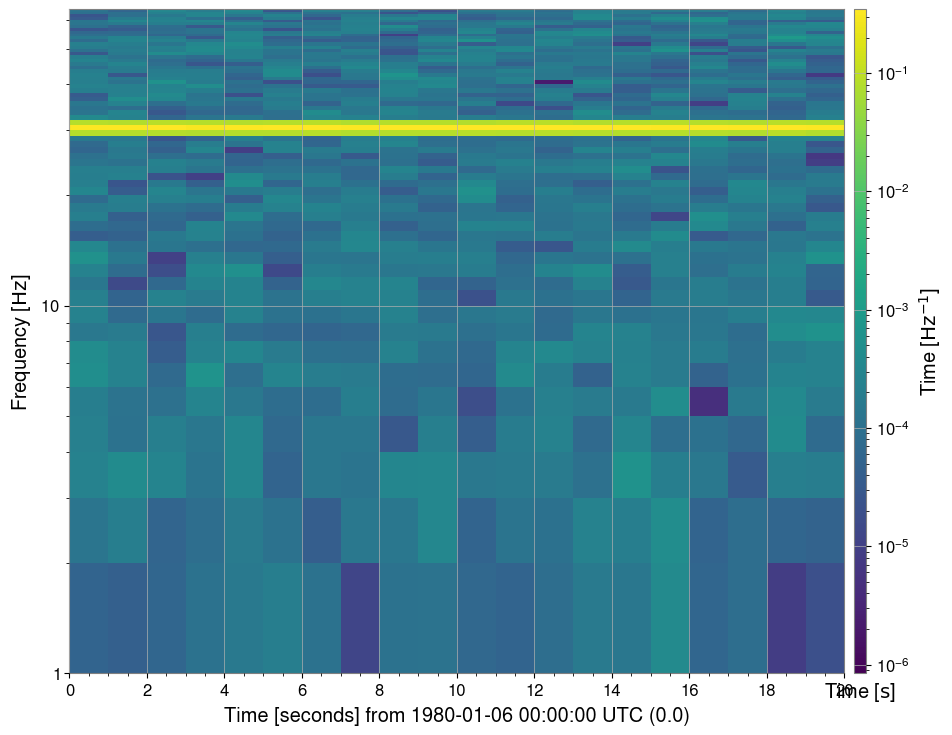

In [5]:
spec_dict = SpectrogramDict({
    'CH1': spec1,
    'CH2': spec2
})

# 一括プロット（軸共有）
plot = spec_dict.plot(sharex=True, sharey=True, figsize=(10, 8))
plot.show()

<a id="matrix"></a>
## 4. 行列形式への変換と機械学習連携

`to_matrix()` メソッドにより、`(Channels, Time, Frequency)` の3次元配列を持つ `SpectrogramMatrix` に変換できます。これは機械学習フレームワークへの入力として最適です。

In [6]:
matrix = spec_list.to_matrix()
print(f"Matrix Type: {type(matrix)}")
print(f"Shape: {matrix.shape} (N, Time, Freq)")

# 時間軸と周波数軸の取得
print(f"Times: {matrix.times.shape}")
print(f"Frequencies: {matrix.frequencies.shape}")

# PyTorch Tensor への変換（PyTorchがインストールされている場合）
try:
    tensor = matrix.to_torch()
    print(f"Tensor Shape: {tensor.shape}")
except ImportError:
    print("PyTorch not installed")

Matrix Type: <class 'gwexpy.spectrogram.matrix.SpectrogramMatrix'>
Shape: (2, 20, 65) (N, Time, Freq)
Times: (20,)
Frequencies: (65,)


Tensor Shape: torch.Size([2, 20, 65])
